<a href="https://colab.research.google.com/github/JerKeller/MP-Ecotaxa/blob/main/ecotaxa_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Importing libraries
import pandas as pd
import numpy as np
import os
import sys
import subprocess
from plotnine import ggplot, aes, geom_point, geom_line, labs, ggtitle, scale_y_log10
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from google.colab import drive

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
ecotaxa_export = '/content/drive/MyDrive/Ecotaxa_analysis/ecotaxa_export.tsv'
tsv_read = pd.read_csv(ecotaxa_export, sep='\t')

In [6]:
# Load data and extract columns needed
sub1 = tsv_read[['object_id', 'object_date', 'object_depth_min', 'object_depth_max', 'object_annotation_category',
                 'object_area', 'object_area_exc', 'object_major', 'object_minor', 'sample_tot_vol', 'process_particle_pixel_size_mm',
                 'acq_id']]

In [7]:
# Modify names of columns
sub1.columns = ['Label', 'Date', 'Min_depth', 'Max_depth', 'Taxa', 'area', 'areaExc', 'major', 'minor',
                'Tow_Vol', 'pixel_size_mm', 'acq_id']

# Remove not living organisms
sub2 = sub1[(sub1['Taxa'] != 'badfocus<artefact') & (sub1['Taxa'] != 'fiber<detritus') & 
            (sub1['Taxa'] != 'multiple<other') & (sub1['Taxa'] != 'detritus') & 
            (sub1['Taxa'] != 'egg sac<egg') & (sub1['Taxa'] != 't001') & 
            (sub1['Taxa'] != 't002') & (sub1['Taxa'] != 't003') & 
            (sub1['Taxa'] != 'othertocheck') & (sub1['Taxa'] != 'artefact') & 
            (sub1['Taxa'] != 'bubble') & (sub1['Taxa'] != 'dead<Copepoda')].copy()


In [8]:
sub2watercol = sub2[~sub2['acq_id'].isin(['tot_n10_221027', 'tot_n9_221013', 'tot_n14_221103',
                                           'tot_n19_221110', 'tot_n24_221221', 'tot_n25_221221',
                                           'tot_n26_221221', 'tot_n27_221221', 'tot_n28_221221',
                                           'tot_n29_221221','tot_n32_221221','tot_n35_221221',
                                          'tot_n38_221221','tot_n41_221221','tot_n42_221221',
                                          'tot_n43_221221','tot_n46_221221'])].copy()

In [9]:
# Convert date to datetime format
sub2watercol['Date'] = pd.to_datetime(sub2watercol['Date'], format='%Y%m%d')

Conversions from pixel to mm

In [10]:
# Conversions from pixel to mm
sub2watercol['Area_mm2'] = sub2watercol['area'] * ((sub2watercol['pixel_size_mm']) ** 2)
sub2watercol['AreaExc_mm2'] = sub2watercol['areaExc'] * ((sub2watercol['pixel_size_mm']) ** 2)
sub2watercol['Major_mm'] = sub2watercol['major'] * sub2watercol['pixel_size_mm']
sub2watercol['Minor_mm'] = sub2watercol['minor'] * sub2watercol['pixel_size_mm']

Ellipsoidal Volume = V (mm3) = 4/3 x ∏ x [ (Major(mm)/2) x (Minor(mm)/2) x (Minor(mm)/2) ]

In [11]:
sub2watercol['V_mm3'] = (4 / 3) * np.pi * ((sub2watercol['Major_mm'] / 2) * (sub2watercol['Minor_mm'] / 2) * (sub2watercol['Minor_mm'] / 2))

Creates a factor which allows binning by the log of the biovolume

In [12]:
sub2watercol['logvol'] = np.log10(sub2watercol['V_mm3'])

In [13]:
grouped_data = sub2watercol.groupby(['acq_id', 'Taxa', 'Date'])

In [14]:
print(grouped_data)

In [15]:
species_count_data = grouped_data.agg({'Taxa': 'count', 'Tow_Vol': 'mean'}).rename(columns={'Taxa': 'Count', 'Tow_Vol': 'tv'})

In [16]:
print(species_count_data)

                                                   Count      tv
acq_id         Taxa                    Date                     
tot_n11_221027 Bythotrephes longimanus 2022-10-27      4  7.0686
               Cyclops prealpinus      2022-10-27    447  7.0686
               Daphnia<Daphniidae      2022-10-27     11  7.0686
               Eubosmina sp            2022-10-27     16  7.0686
               Eudiaptomus gracilis    2022-10-27    574  7.0686
...                                                  ...     ...
tot_n8_221013  Daphnia<Daphniidae      2022-10-13     75  3.5343
               Eubosmina sp            2022-10-13      4  3.5343
               Eudiaptomus gracilis    2022-10-13    220  3.5343
               Leptodora kindtii       2022-10-13      1  3.5343
               nauplii<Copepoda        2022-10-13     65  3.5343

[189 rows x 2 columns]


In [17]:
concentration_data = species_count_data.copy()
concentration_data['Concentration'] = concentration_data['Count'] / concentration_data['tv']
concentration_data.reset_index(inplace=True)

In [18]:
print(concentration_data)

             acq_id                     Taxa       Date  Count      tv  \
0    tot_n11_221027  Bythotrephes longimanus 2022-10-27      4  7.0686   
1    tot_n11_221027       Cyclops prealpinus 2022-10-27    447  7.0686   
2    tot_n11_221027       Daphnia<Daphniidae 2022-10-27     11  7.0686   
3    tot_n11_221027             Eubosmina sp 2022-10-27     16  7.0686   
4    tot_n11_221027     Eudiaptomus gracilis 2022-10-27    574  7.0686   
..              ...                      ...        ...    ...     ...   
184   tot_n8_221013       Daphnia<Daphniidae 2022-10-13     75  3.5343   
185   tot_n8_221013             Eubosmina sp 2022-10-13      4  3.5343   
186   tot_n8_221013     Eudiaptomus gracilis 2022-10-13    220  3.5343   
187   tot_n8_221013        Leptodora kindtii 2022-10-13      1  3.5343   
188   tot_n8_221013         nauplii<Copepoda 2022-10-13     65  3.5343   

     Concentration  
0         0.565883  
1        63.237416  
2         1.556178  
3         2.263532  
4     

In [19]:
biovolume_data = sub2watercol.groupby(['Taxa', 'Date']).agg({'Tow_Vol': 'mean', 'V_mm3': 'sum'})
biovolume_data['Biovolume'] = biovolume_data['V_mm3'] / biovolume_data['Tow_Vol']
biovolume_data.reset_index(inplace=True)

concentration_data = concentration_data.merge(biovolume_data[['Taxa', 'Date','Biovolume']], on=['Taxa', 'Date'])

In [20]:
print(concentration_data)

             acq_id                     Taxa       Date  Count      tv  \
0    tot_n11_221027  Bythotrephes longimanus 2022-10-27      4  7.0686   
1    tot_n11_221027       Cyclops prealpinus 2022-10-27    447  7.0686   
2    tot_n11_221027       Daphnia<Daphniidae 2022-10-27     11  7.0686   
3    tot_n11_221027             Eubosmina sp 2022-10-27     16  7.0686   
4    tot_n11_221027     Eudiaptomus gracilis 2022-10-27    574  7.0686   
..              ...                      ...        ...    ...     ...   
184   tot_n8_221013     Eudiaptomus gracilis 2022-10-13    220  3.5343   
185   tot_n7_221013         nauplii<Copepoda 2022-10-13      1  3.5343   
186   tot_n8_221013         nauplii<Copepoda 2022-10-13     65  3.5343   
187   tot_n8_221013  Bythotrephes longimanus 2022-10-13      1  3.5343   
188   tot_n8_221013        Leptodora kindtii 2022-10-13      1  3.5343   

     Concentration  Biovolume  
0         0.565883   0.992754  
1        63.237416  14.358739  
2         1.556

Total biovolume and concentration by sample

In [22]:
total_conc = concentration_data.groupby('acq_id').agg({'Count': 'sum', 'tv': 'sum', 'Concentration': 'sum', 'Biovolume': 'sum','Date': 'first'}).reset_index()

In [23]:
cyclopsEudia = ["Cyclops prealpinus","Eudiaptomus gracilis","nauplii<Copepoda"]
concentration_data_cyclops = concentration_data.query('Taxa in @cyclopsEudia')

In [24]:
DaphEubos = ["Daphnia<Daphniidae","Eubosmina sp"]
concentration_data_daph = concentration_data.query('Taxa in @DaphEubos')

In [25]:
LeptoBitho = ["Leptodora kindtii","Bythotrephes longimanus",]
concentration_data_lepto = concentration_data.query('Taxa in @LeptoBitho')

In [26]:
grouped_conc_data = concentration_data.groupby(['Taxa', 'Date'])['Concentration'].sum().reset_index()

In [27]:
group_cyclopsEudia = ["Cyclops prealpinus","Eudiaptomus gracilis","nauplii<Copepoda"]
grouped_data_cyclops = grouped_conc_data.query('Taxa in @group_cyclopsEudia')

In [28]:
group_dapheubo = ["Daphnia<Daphniidae","Eubosmina sp"]
grouped_data_dapheubo = grouped_conc_data.query('Taxa in @group_dapheubo')

In [29]:
group_leptobitho = ["Leptodora kindtii","Bythotrephes longimanus"]
grouped_data_leptobitho = grouped_conc_data.query('Taxa in @group_leptobitho')

Total concentration plot

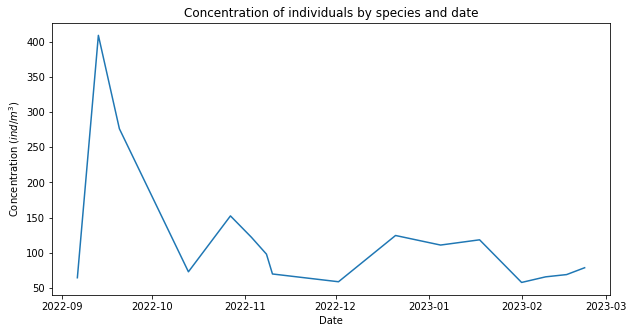

In [30]:
plt.figure(figsize=(10, 5))
sns.lineplot(x="Date", y="Concentration", data=total_conc, markers=True, ci=None)
plt.title("Concentration of individuals by species and date")
plt.xlabel("Date")
plt.ylabel("Concentration ($ind/m^3$)")
plt.show()

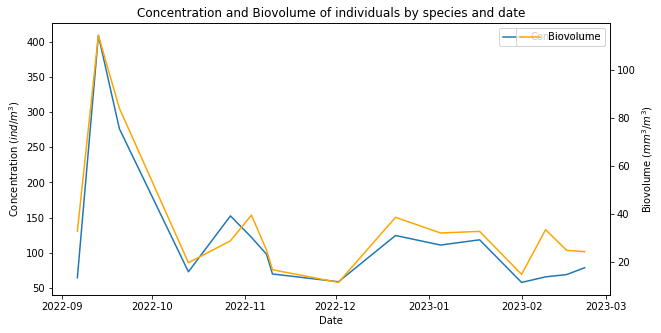

In [31]:
fig, ax1 = plt.subplots(figsize=(10, 5))

# plot the first variable (Concentration) on the left y-axis
sns.lineplot(x="Date", y="Concentration", data=total_conc, markers=True, ax=ax1, ci=None, label = "Concentration")
ax1.set_xlabel('Date')
ax1.set_ylabel('Concentration ($ind/m^3$)')


ax2 = ax1.twinx()


sns.lineplot(x="Date", y="Biovolume", data=total_conc, markers=True, ax=ax2, color='orange', ci=None, label = "Biovolume")
ax2.set_ylabel('Biovolume ($mm^3/m^3$)')

plt.title("Concentration and Biovolume of individuals by species and date")
plt.legend()
plt.show()







Concentration by taxa

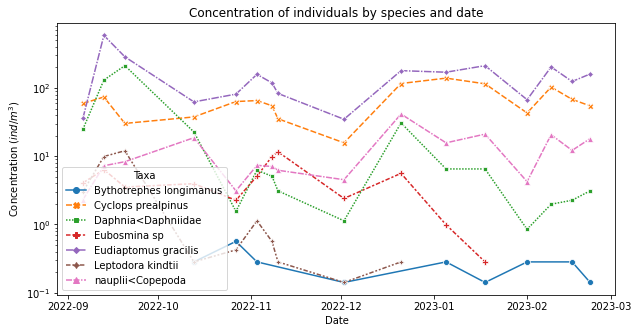

In [29]:
plt.figure(figsize=(10, 5))
sns.lineplot(x="Date", y="Concentration", hue="Taxa", data=grouped_conc_data, style="Taxa", markers=True)
plt.yscale("log") # add logarithmic scale
plt.title("Concentration of individuals by species and date")
plt.xlabel("Date")
plt.ylabel("Concentration ($ind/m^3$)")
plt.show()

Biovolume for Cyclops, eudiaptomus and nauplii

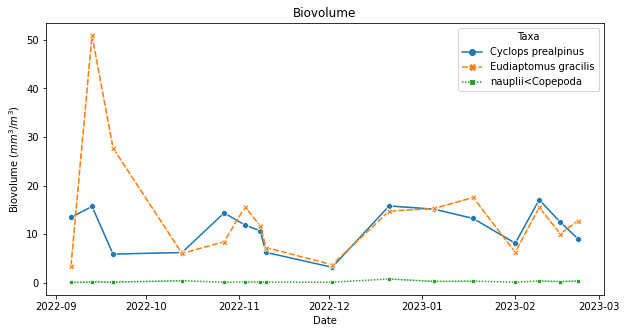

In [30]:
plt.figure(figsize=(10, 5))
sns.lineplot(x="Date", y="Biovolume", hue="Taxa", data=concentration_data_cyclops, style="Taxa", markers=True)
#plt.yscale("log") # add logarithmic scale
plt.title("Biovolume")
plt.xlabel("Date")
plt.ylabel("Biovolume ($mm^3$/$m^3$)")
plt.show()

Concentration for cyclops, eudiaptomus and nauplii

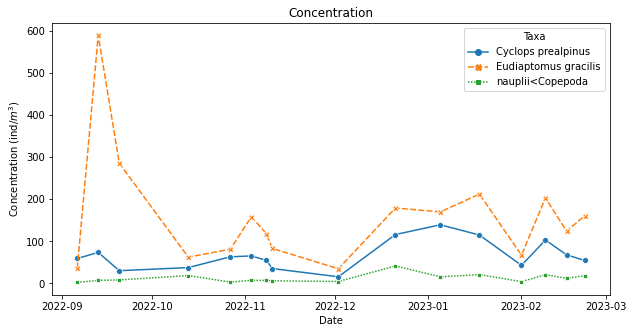

In [ ]:
plt.figure(figsize=(10, 5))
sns.lineplot(x="Date", y="Concentration", hue="Taxa", data=grouped_data_cyclops, style="Taxa", markers=True)
#plt.yscale("log") # add logarithmic scale
plt.title("Concentration")
plt.xlabel("Date")
plt.ylabel("Concentration (ind/$m^3$)")
plt.show()

Biovolume for daphnia and eubosmina

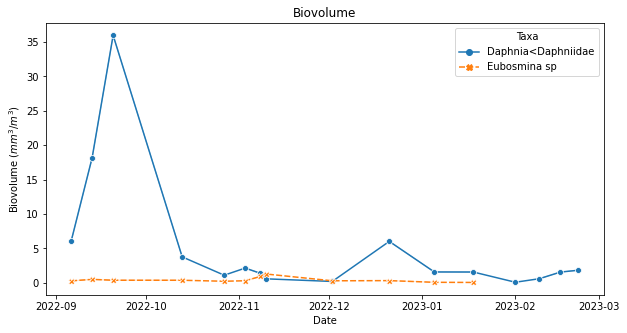

In [ ]:
plt.figure(figsize=(10, 5))
sns.lineplot(x="Date", y="Biovolume", hue="Taxa", data=concentration_data_daph, style="Taxa", markers=True)
#plt.yscale("log") # add logarithmic scale
plt.title("Biovolume")
plt.xlabel("Date")
plt.ylabel("Biovolume ($mm^3$/$m^3$)")
plt.show()

Concentration for daphnia and eubosmina

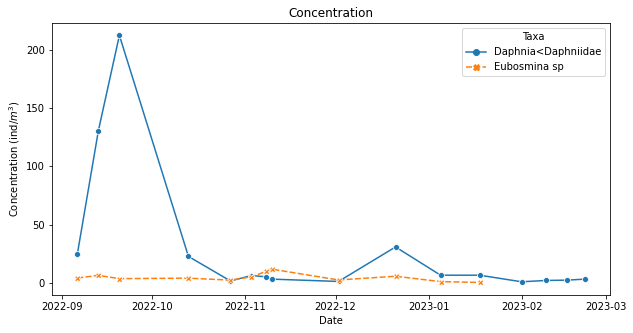

In [ ]:
plt.figure(figsize=(10, 5))
sns.lineplot(x="Date", y="Concentration", hue="Taxa", data=grouped_data_dapheubo, style="Taxa", markers=True)
#plt.yscale("log") # add logarithmic scale
plt.title("Concentration")
plt.xlabel("Date")
plt.ylabel("Concentration (ind/$m^3$)")
plt.show()

Biovolume for bythotrephes and leptodora

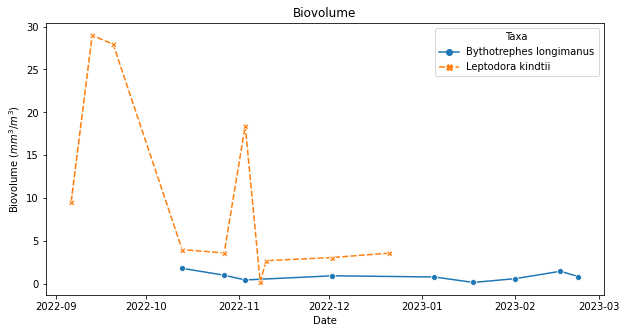

In [ ]:
plt.figure(figsize=(10, 5))
sns.lineplot(x="Date", y="Biovolume", hue="Taxa", data=concentration_data_lepto, style="Taxa", markers=True)
#plt.yscale("log") # add logarithmic scale
plt.title("Biovolume")
plt.xlabel("Date")
plt.ylabel("Biovolume ($mm^3$/$m^3$)")
plt.show()

Concentration for bythotrephes and leptodora

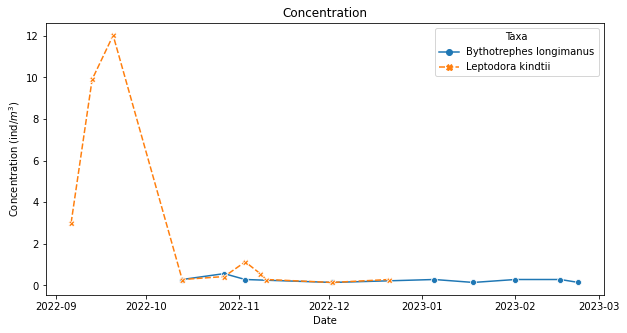

In [ ]:
plt.figure(figsize=(10, 5))
sns.lineplot(x="Date", y="Concentration", hue="Taxa", data=grouped_data_leptobitho, style="Taxa", markers=True)
#plt.yscale("log") # add logarithmic scale
plt.title("Concentration")
plt.xlabel("Date")
plt.ylabel("Concentration (ind/$m^3$)")
plt.show()

In [ ]:
species_to_plot = ["cyclops préalpinus", "eudiaptomus gracilis"]
concentration_data_filtered = concentration_data.query('Taxa in @species_to_plot')

In [ ]:
grouped_conc_data = grouped_conc_data.sort_values(by='Date')

In [ ]:
grouped_conc_data['Date'] = grouped_conc_data['Date'].dt.date

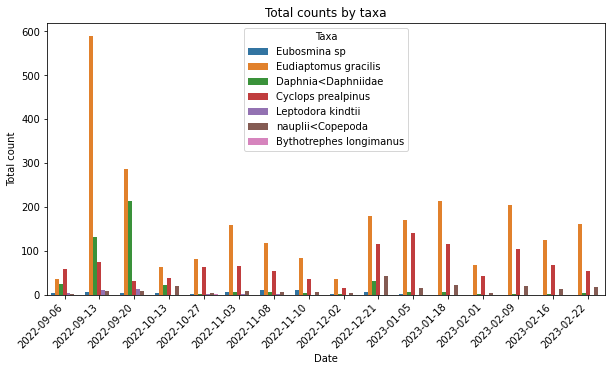

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x="Date", y="Concentration",hue="Taxa", data=grouped_conc_data, ci=None)
plt.title("Total counts by taxa")
plt.xlabel("Date")
plt.ylabel("Total count")
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
concentration_data = concentration_data.sort_values(by='Date')



<Figure size 720x360 with 0 Axes>

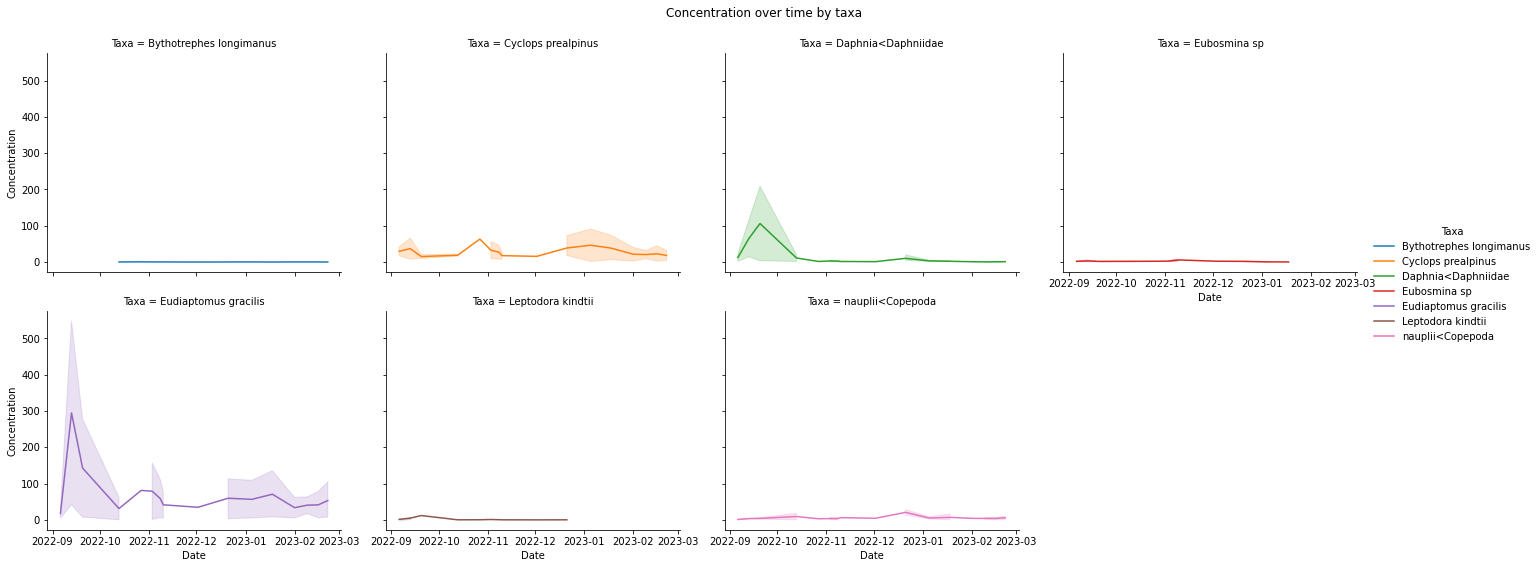

In [ ]:
plt.figure(figsize=(10,5))
sns.relplot(x="Date", y="Concentration", hue="Taxa", kind="line", col="Taxa", col_wrap=4, data=concentration_data, height=4, aspect=1.2)
plt.subplots_adjust(top=0.9)
plt.suptitle("Concentration over time by taxa")
plt.show()

In [ ]:
print(concentration_data.columns)

Index(['acq_id', 'Taxa', 'Date', 'Count', 'tv', 'Concentration'], dtype='object')


In [ ]:
# Group the data by date and taxa

grouped_data <- sub2watercol %>%
  group_by(acq_id, Taxa, Date)


# Count the number of occurrences for each species on each date

species_count_data <- grouped_data %>%
  summarise(Count = n(), tv = mean(Tow_Vol) )

# Count the number of occurrences for each species on each date

#species_count_data <- grouped_data %>%
  #summarise(Count = n(), tv = mean(Tow_Vol) )

# Divide the total count by the total volume filtered to get the concentration

concentration_data <- species_count_data %>% 
  mutate(Concentration = Count / tv)


SyntaxError: ignored

In [ ]:

# Biovolume = Bv (mm3/m3) = (Spherical Volume x acq_sub_part) / sample_tot_vol
# sub2watercol['Biovolume_ellips_mm3_m2'] = sub2watercol['V_mm3'] / sub2watercol['Tow_Vol']

# Grouper les biovolumes par dates et espèces
# grouped_data_biovol <- aggregate(Biovolume_ellips_mm3_m2 ~ Date + Taxa, data = sub2, FUN = sum)

# Group the data by date and taxa
grouped_data = sub2watercol.groupby(['acq_id', 'Taxa', 'Date'])

# Count the number of occurrences for each species on each date
species_count



SyntaxError: ignored